### Visualización y Preprocesamiento de los datos

En este notebook utilizaremos el conjunto que hemos inspeccionado y adecuado para crear unas sencillas representaciones de los datos  y posteriormente aplicar tecnica de preprocesamiento realizar un sencillo modelo que nos ayude a analizar los sentimientos descritos en las diferentes reseñas. Así, el siguiente script está dividido en los siguientes bloques:

- **BLOQUE A**: carga de datos inspeccionados.
- **BLOQUE B**: visualización. 
- **BLOQUE C**: preprocesamiento del texto.
- **BLOQUE D**: balanceo de los datos
- **BLOQUE D**: partición del conjunto de datos en train y test.
- **BLOQUE E**: vectorización  del texto.



- **BLOQUE F**: entrenamiento de distintos modelos.
- **BLOQUE G**: inferencia sobre los datos de test.
- **BLOQUE H**: exportación de uno de los modelos.

In [20]:
import pandas as pd
import re
import pickle
import joblib
import random

import seaborn as sns
import matplotlib.pyplot as plt 

from wordcloud import WordCloud
import nltk

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report


In [2]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/vincenzo.germinara/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     /home/vincenzo.germinara/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

### BLOQUE A: Carga de datos
Antes de comenzar, cargaremos los datos que han sido adecuados en nuestra fase anterior de limpieza

In [4]:
# Carga de datos ya adecuados
df = pd.read_csv('../data/spam_filtered.csv')

In [5]:
# ¿Que dimensiones tiene el conjunto de datos?
df.shape

(4028, 3)

In [6]:
# Mostramos las primeras observaciones del conjunto
df.head()

,target,text,length
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
2,ham,U dun say so early hor... U c already then say...,49
3,ham,"Nah I don't think he goes to usf, he lives aro...",61
4,spam,FreeMsg Hey there darling it's been 3 week's n...,148


### BLOQUE B: visualización

En este bloque utilizaremos las librerias [matplotlib](https://matplotlib.org/) y [seaborn](https://seaborn.pydata.org/) para crear unas sencillas representaciones de los datos a modo general y descriptivo, mientras que  nos ayudaremos de la librería [wordcloud](https://amueller.github.io/word_cloud/) para poder crear visualizaciones acerca de los textos que vamos a analizar.

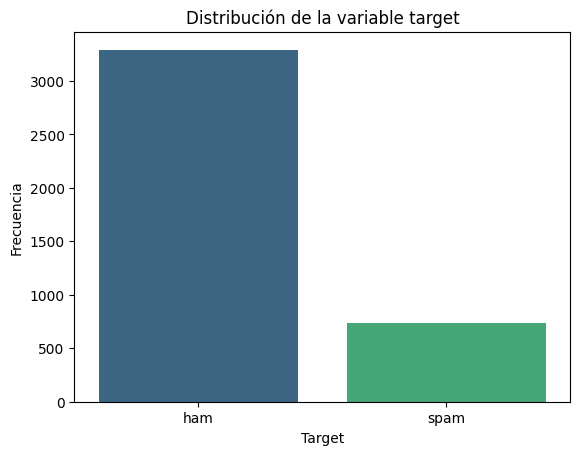

In [7]:
# Gráfico de barras para la variable sentiment
sns.countplot(x='target', palette='viridis', data=df)
plt.title('Distribución de la variable target')
plt.ylabel('Frecuencia')
plt.xlabel('Target')
plt.show()

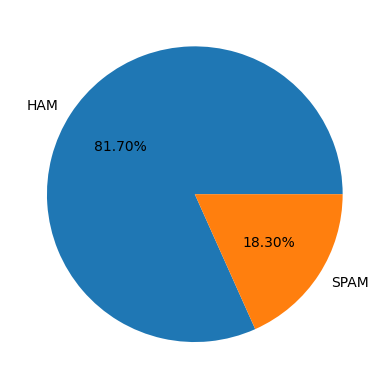

In [8]:
# Gráfico 'pie' con porcentajes para la variable objetivo 
plt.pie(df['target'].value_counts(), autopct="%.2f%%", labels=['HAM', 'SPAM'])
plt.show()

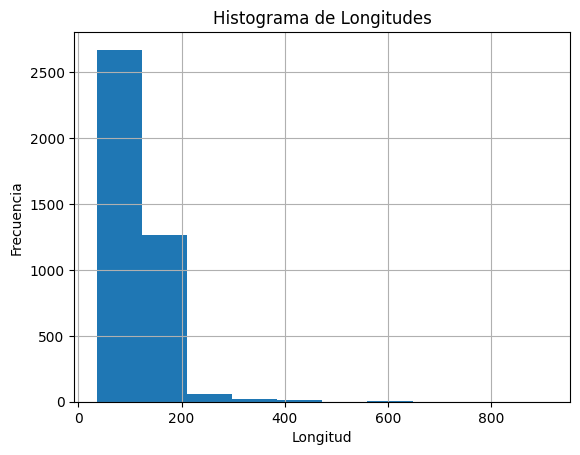

In [9]:
# Histograma de la distribución de las logitudes de las reselas.
# Utilizamos los histogramas proporcionados por el propio dataframe.
df['length'].hist()
plt.title('Histograma de Longitudes')
plt.xlabel('Longitud')
plt.ylabel('Frecuencia')
plt.show()

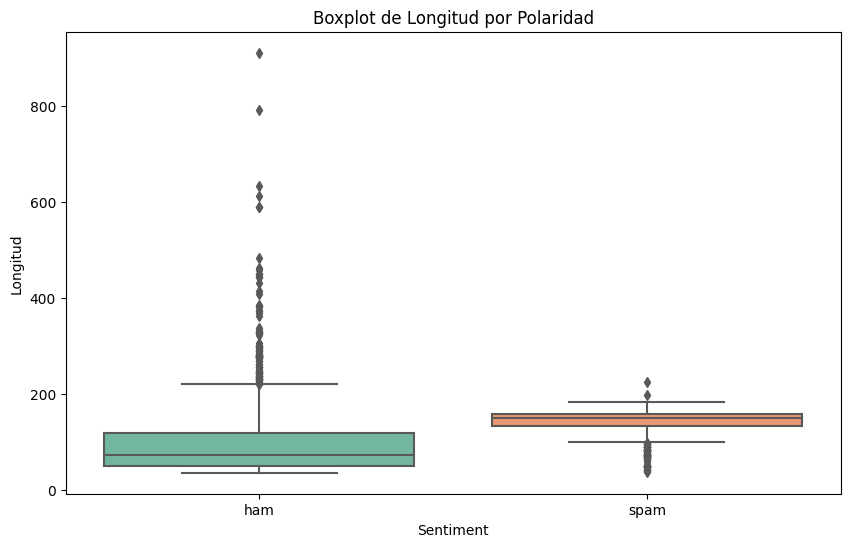

In [10]:
# Distribución de la Longitud por cada tipo de clase
plt.figure(figsize=(10, 6))

sns.boxplot(x='target', y='length', data=df, palette='Set2')

plt.title('Boxplot de Longitud por Polaridad')
plt.xlabel('Sentiment')
plt.ylabel('Longitud')
plt.show()

##### Vamos a crear un gráfico de las palabras más comunes en las reseñas de cada tipo de sentimiento

In [ ]:
# Filtramos los textos por sus etiquetas

# textos no spam
ham_texts = df.loc[df['target']=='ham', 'text']

# textos spam
spam_texts = df.loc[df['target']=='spam', 'text']

In [12]:
# Función para poder realizar el gráfico
def wordcloud_draw(data, color, title):
    words = ' '.join(data)
    wordcloud = WordCloud(stopwords=stopwords.words('english'),
                          background_color=color,
                          width=2500,height=2000).generate(words)
    plt.imshow(wordcloud)
    plt.title(title)
    plt.axis('off')

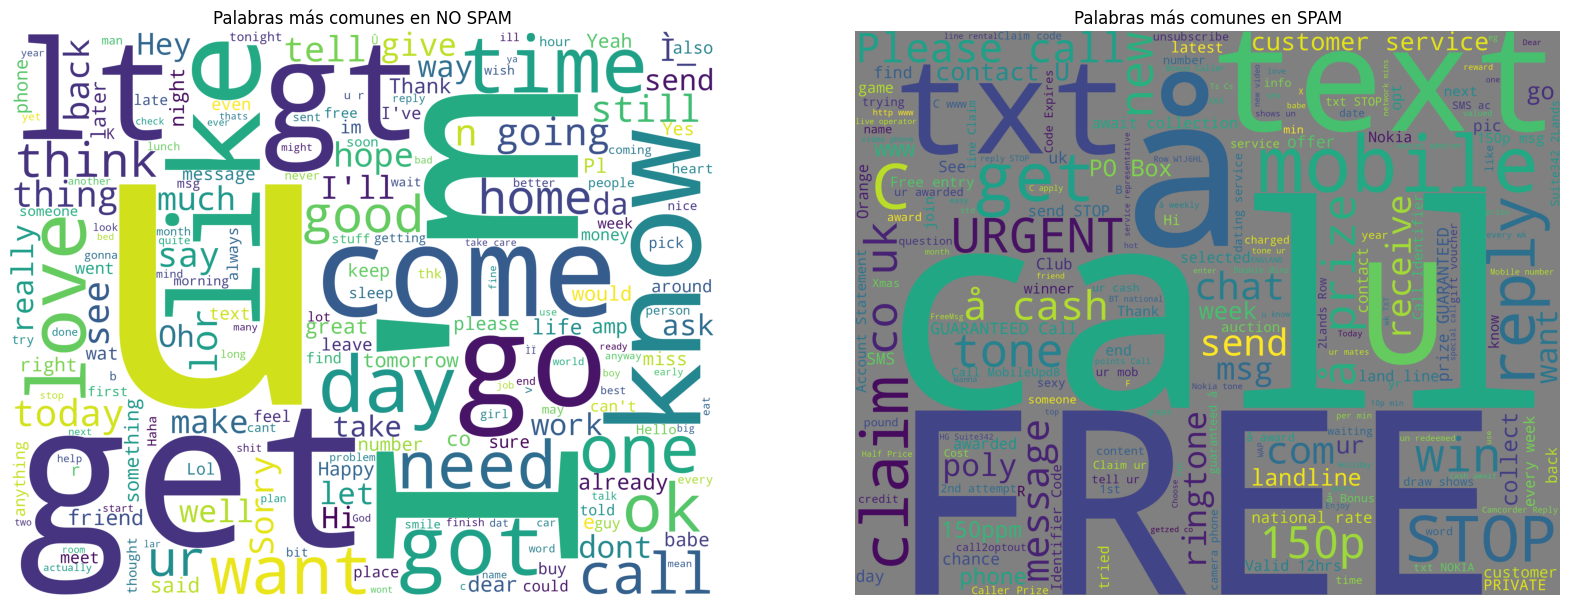

In [13]:
# Representamos los dos gráficos en una sola visualización
plt.figure(figsize=[20,10])
plt.subplot(1,2,1)
wordcloud_draw(ham_texts,'white','Palabras más comunes en NO SPAM')

plt.subplot(1,2,2)
wordcloud_draw(spam_texts, 'grey','Palabras más comunes en SPAM')
plt.show()

### BLOQUE C: Preprocesamiento del texto

El preprocesamiento del texto es una fase importante dentro del Procesamiento del Lenguaje Natural (NLP). El objetivo de esta fase es la de transformar el texto en crudo, de manera que sea más fácilmente consumible por los algoritmos y modelos de Machine Learning (ML) y Deep Learning (DL) a aplicar.

Esta fase consta de diferentes pasos y no son siempre los mismos. En este caso, preprocesaremos las reseñas de la siguiente manera:

1. **Lower Casing**: Transformar palabras de mayúsculas a minúsculas.

2. **Eliminar Non-Alphabets**: Reemplazar todos los caracteres excepto alphabets por un espacio.

3. **Eliminar letras consecutivas**: 3 o más letras consecutivas son reemplazadas por 2 letras (ejemplo: "Heyyyy" por "Heyy").

4. **Tokenizacíon**:  proceso de dividir un texto en unidades más pequeñas llamadas tokens (palabras).

5. **Eliminar Stopwords**: Las Stopwords son aquellas palabras en ingés que no tienen un significado específico por si solas, por lo que pueden ser ignoradas sin sacrificar el significado de la oración (ejemplos: "the", "a").

6. **Eliminar palabras cortas**: Palabras con menos de 2 letras son eliminadas.

In [ ]:
# Función para preprocesar el texto en crudo
def preprocess(text):    

    # Definir patrones para reemplazar/eliminar.
    alphaPattern      = "[^a-zA-Z]"
    sequencePattern   = r"(.)\1\1\1*"
    seqReplacePattern = r"\1\1"    

    
    # Crear lista de stopwords
    en_stop =  set(stopwords.words('english')) - {'not','no'}  # o definirlo manualmente set(['a', 'an', 'the', 'in', 'does', 'do'])

    # Lower Casing
    text = text.lower()

    # Reemplazar non-alphabets.
    text = re.sub(alphaPattern, " ", text)

     # Reemplazar letras consecutivas.
    text = re.sub(sequencePattern, seqReplacePattern, text)
    
    # Tokenizar texto
    tokens = word_tokenize(text)

    # Eliminar stopwords
    tokens = [word for word in tokens if word not in en_stop]
    
    # Eliminar stringas con menos de dos elementos
    tokens = [word for word in tokens if len(word)>2]
    
        
    return tokens

In [16]:
# Aplicamos la función a cada una de las reseñas
df['preprocess_text'] = df['text'].apply(preprocess)

In [19]:
# Resultados del preprocesamiento: un ejemplo
print('Texto en crudo:', df.loc[0, 'text'])
print('Texto preprocesado:', df.loc[0, 'preprocess_text'])

Texto en crudo: Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...
Texto preprocesado: ['jurong', 'point', 'crazy', 'available', 'bugis', 'great', 'world', 'buffet', 'cine', 'got', 'amore', 'wat']


### BLOQUE D: Balanceo de los datos

In [27]:
# Separar clases
spam = df[df['target'] == 'spam']
no_spam = df[df['target'] == 'ham']

# Submuestrear la clase mayoritaria
no_spam_resampled = resample(no_spam, 
                             replace=False,  # sin reemplazo
                             n_samples=len(spam),  # igualar tamaño al de "spam"
                             random_state=42)

# Combinar clases balanceadas
balanced_df = pd.concat([spam, no_spam_resampled])

In [28]:
balanced_df.target.value_counts()

target
spam    737
ham     737
Name: count, dtype: int64

### BLOQUE E: Partición del conjunto de datos en train y test (80,20)

In [31]:
X = balanced_df['preprocess_text']
y = balanced_df['target']

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [32]:
# Información acerca de los conjuntos
print('Tamaño del conjunto de entrenamiento:', len(X_train))
print('Tamaño del conjunto de test:', len(X_test))

Tamaño del conjunto de entrenamiento: 1179
Tamaño del conjunto de test: 295


In [33]:
# Frequencias relativas de 'Target' en el conjunto de intrenamiento
round(y_train.value_counts(normalize=True), 2)

target
spam    0.5
ham     0.5
Name: proportion, dtype: float64

In [34]:
# Frequencias relativas de 'Target' en el conjunto de test
round(y_test.value_counts(normalize=True), 2)

target
ham     0.5
spam    0.5
Name: proportion, dtype: float64

### BLOQUE E: Vectorización del texto

Antes de dar el texto en input a un modelo es necesario vectorizarlo: convertir las palabras en números.

La conversión del texto en una representación númerica es uno de los pasos más importantes dentro de cualquier *pipeline* de NLP. Esta conversión resulta esencial para que las "máquinas" puedan comprender y decodificar patrones dentro de cualquier lenguaje.

Se trata de un proceso iterativo y que puede ser realizado mediante múltiples maneras o técnicas, abarcando desde las representaciones más sencillas (por ejemlo, One hot encoding) hasta otras más "inteligentes", que logran tener en cuenta las similitudes y diferencias entre ellas al basar su aprendizaje en redes neuronales (Word embeddings).

En este caso vamos a utilizar la técnica TF-IDF (Term Frequency-Inverse Document Frequency). A continuación, se describen los conceptos clave:

1. Term Frequency (TF):
Mide la frecuencia de un término específico en un documento.
Se calcula dividiendo el número de veces que un término aparece en un documento entre el número total de términos en el documento.
Cuanto más frecuente es un término en un documento, mayor es su valor de TF.

2. Inverse Document Frequency (IDF):
Mide la importancia de un término en el conjunto de documentos.
Se calcula tomando el logaritmo del inverso de la proporción de documentos que contienen el término.
Términos que aparecen en muchos documentos tendrán un IDF más bajo, ya que se consideran menos informativos.
3. TF-IDF:
Combina TF y IDF para asignar un peso a cada término en cada documento. \
**TF-IDF = TF * IDF** \
Los términos que son frecuentes en un documento pero raros en el conjunto de documentos tendrán un alto valor de TF-IDF, lo que indica su importancia relativa en ese documento específico.

In [35]:
# vectorización del texto
vectorizer = TfidfVectorizer() 

# fit_transform() determina qué palabras existen en el conjunto de datos y asigna un índice a cada una de ellas.
X_train_vec = vectorizer.fit_transform([" ".join(tokens) for tokens in X_train])

In [36]:
# transformar nuevos datos en función del vocabulario aprendido anteriormente
X_test_vec = vectorizer.transform([" ".join(tokens) for tokens in X_test])

Vamos a ver con más detalle el objecto generado con TfidfVectorizer:

In [64]:
type(X_train_vec)

scipy.sparse._csr.csr_matrix

 Matriz dispersa (sparse matrix) en el formato CSR (Compressed Sparse Row). Una matriz dispersa es una estructura de datos que se utiliza para almacenar matrices que tienen una gran cantidad de elementos cero.

In [37]:
# Obtener dimensiones
num_documentos, num_terminos = X_train_vec.shape

print(f"Número de Documentos: {num_documentos}")
print(f"Número de Términos: {num_terminos}")


Número de Documentos: 1179
Número de Términos: 3259


In [38]:
# Escogemos 10 palabras al azar  
random.sample(list(vectorizer.get_feature_names_out()), 10)

['rates',
 'sentence',
 'glo',
 'planettalkinstant',
 'rpl',
 'strain',
 'handsome',
 'orange',
 'seem',
 'gist']

Vamos a ver el valor TF-IDF asignados a algunas palabras en el primer documento

In [39]:
# vamos a ver que contiene el primer documento
X_train.iloc[0]

['wan',
 'get',
 'laid',
 'nite',
 'want',
 'real',
 'dogging',
 'locations',
 'sent',
 'direct',
 'mobile',
 'join',
 'largest',
 'dogging',
 'network',
 'txt',
 'park',
 'nyt',
 'msg']

In [42]:
terminos = vectorizer.get_feature_names_out()

# Obtener el primer documento como vector TF-IDF
vector_tfidf_primer_documento = X_train_vec[0]

# Crear un DataFrame para visualizar el resultado
df = pd.DataFrame(vector_tfidf_primer_documento.toarray(), columns=terminos)

# valor TF-IDF asignado a una palabra contenida en el documento
df['get']

0    0.134632
Name: get, dtype: float64

In [43]:
# valor TF-IDF asignado a la palabra no presente en el documento
df['bad']

0    0.0
Name: bad, dtype: float64

In [44]:
type(X_train)

pandas.core.series.Series

### BLOQUE E: Exportación de los conjuntos preprocesados

En esta última fase exportamos y guardamos los conjuntos preprocesados en la carpeta 'data', para poderlos utilizar en las próximas tareas de modelado. 


In [52]:
# ¿De que tipo son los conjuntos resultantes?
print(f'X_train: {type(X_train)}')
print(f'X_train_vec: {type(X_train_vec)}')
print(f'y_train: {type(y_train)}')

X_train: <class 'pandas.core.series.Series'>
X_train_vec: <class 'scipy.sparse._csr.csr_matrix'>
y_train: <class 'pandas.core.series.Series'>


Vamos a guardarlos como archivos binarios utilizando **pickle**, que es una forma general de serializar objetos en Python

In [ ]:
# Guardamos los conjuntos X

with open('../data/x_train.pkl', 'wb') as file:
    pickle.dump(X_train, file)

with open('../data/x_test.pkl', 'wb') as file:
    pickle.dump(X_test, file)

In [ ]:
# Guardamos los conjuntos de textos vectorizados

with open('../data/x_train_vec.pkl', 'wb') as file:
    pickle.dump(X_train_vec, file)

with open('../data/x_test_vec.pkl', 'wb') as file:
    pickle.dump(X_test_vec, file)

In [ ]:
# Guardamos las variables objetivo
with open('../data/y_train.pkl', 'wb') as file:
    pickle.dump(y_train, file)

with open('../data/y_test.pkl', 'wb') as file:
    pickle.dump(y_test, file)

In [58]:
# Guardar el vectorizer en un file 
joblib.dump(vectorizer, '../models/tfidf_vectorizer.joblib')

['../models/tfidf_vectorizer.joblib']